works with kernel Python \[conda env:pangu] as constructed in README

run fengwu with 1 GPU and 20 GB memory (must be v100, not gp100 because gp100 only has 16 GB VRAM, but v100 has 32GB)

Make these the default casper modules `module save`

```
Currently Loaded Modules:
  1) ncarenv/24.12  (S)   3) ncarcompilers/1.0.0   5) ucx/1.17.0      7) hdf5/1.12.3    9) cudnn/9.2.0.82-12
  2) intel/2024.2.1       4) cuda/12.3.2           6) openmpi/5.0.6   8) netcdf/4.9.2  10) conda/latest
```

Inferences in conda env:ainwp is different by 0.0001 K from pangu env (after 240 hours)
conda env:ainwp is supposed to replicate realtime runs, but still 0.1 K different from realtime runs

In [1]:
from pathlib import Path

import pandas as pd
import xarray as xr
from hwt_mpas import MPASDataSource
from run_pangu import plot_ensemble
from run_pangu.s3_run_pangu_ecmwf import run_inference, setup_model_sessions

ai_models_dir = Path("/glade/derecho/scratch/ahijevyc/ai-models")
date = pd.to_datetime("2024042500", format="%Y%m%d%H")
ic = "mpas"
fhr_end = 240

In [2]:
!uname -a

Linux casper42 5.14.21-150400.24.46-default #1 SMP PREEMPT_DYNAMIC Thu Feb 9 08:38:18 UTC 2023 (2d95137) x86_64 x86_64 x86_64 GNU/Linux


In [3]:
mpas15km_datasrc = MPASDataSource(
    grid_path=Path("MPAS/15km_mesh/grid_mesh/x1.2621442.grid.nc"),
    data_dir=f"HWT{date.year}/mpas_15km",
)
if False:
    mpas15_3km_datasrc = MPASDataSource(
        grid_path=Path("MPAS/15-3km_mesh/grid_mesh/x5.6488066.grid_CONUS.nc"),
        data_dir=f"HWT{date.year}/mpas",
    )
ds_mpas = mpas15km_datasrc(date, 24)#, variables=["t850"])
ds_mpas

Loading cached indices from /glade/derecho/scratch/ahijevyc/ai-models/x1.2621442.grid.npz


2025-09-03 11:20:51,781 - INFO - decode initialization time variable
2025-09-03 11:20:51,797 - INFO - decode valid time and assign to variable
2025-09-03 11:20:51,830 - INFO - decode initialization time variable
2025-09-03 11:20:51,935 - INFO - decode valid time and assign to variable
2025-09-03 11:20:52,104 - INFO - decode initialization time variable
2025-09-03 11:20:52,126 - INFO - decode valid time and assign to variable
2025-09-03 11:20:52,295 - INFO - decode initialization time variable
2025-09-03 11:20:52,323 - INFO - decode valid time and assign to variable
2025-09-03 11:20:52,494 - INFO - decode initialization time variable
2025-09-03 11:20:52,505 - INFO - decode valid time and assign to variable
2025-09-03 11:20:52,693 - INFO - decode initialization time variable
2025-09-03 11:20:52,712 - INFO - decode valid time and assign to variable
2025-09-03 11:20:52,918 - INFO - decode initialization time variable
2025-09-03 11:20:52,937 - INFO - decode valid time and assign to variable

<xarray.Dataset> Size: 3GB
Dimensions:  (member: 10, time: 1, lat: 721, lon: 1440)
Coordinates:
  * member   (member) int64 80B 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 8B 2024-04-26
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables: (12/69)
    t2m      (member, time, lat, lon) float32 42MB 260.5 260.5 ... 203.5 203.5
    u10m     (member, time, lat, lon) float32 42MB -4.039 -4.039 ... -2.624
    v10m     (member, time, lat, lon) float32 42MB 0.5885 0.5885 ... -1.934
    msl      (member, time, lat, lon) float32 42MB 1.034e+05 ... 6.648e+04
    t1000    (member, time, lat, lon) float32 42MB 258.7 258.7 ... 208.3 208.3
    u1000    (member, time, lat, lon) float32 42MB -4.6 -4.6 ... -3.882 -3.882
    ...       ...
    q100     (member, time, lat, lon) float32 42MB 5.333e-06 ... 4.178e-06
    t50      (member, time, lat, lon) float32 42MB 225.4 225.4 ... 214.5 214.5
    u50      (member, time, lat, lon) float32 42MB 14.36 14.36 ... 2.218 2.218
    v50      (member, time, lat, lon) float32 42MB -9.245 -9.245 ... 6.332 6.332
    z50      (member, time, lat, lon) float32 42MB 1.126e+05 ... 1.031e+05
    q50      (member, time, lat, lon) float32 42MB 5.333e-06 ... 4.178e-06
Attributes:
    initialization_time:  2024-04-25 00:00:00
    forecast_hour:        24

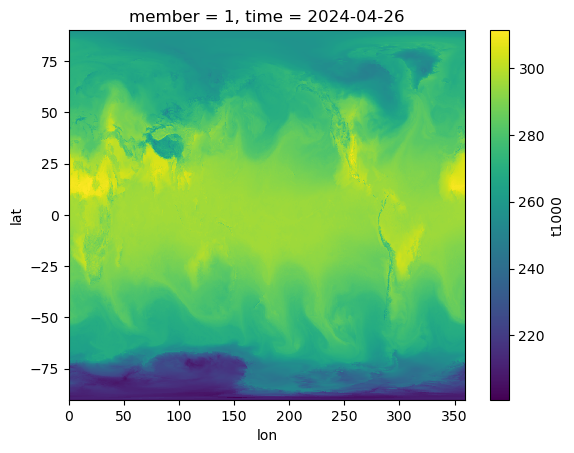

In [4]:
ds_mpas["t1000"].sel(member=1).squeeze().plot()

In [5]:
ort_session_24, ort_session_6 = setup_model_sessions(ai_models_dir)

2025-09-03 11:23:17.167903217 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn.so.9: cannot open shared object file: No such file or directory

2025-09-03 11:23:17.167982134 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2025-09-03 11:23:22.123393917 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.

In [11]:
ds_mpas.to_array(dim="channel")

<xarray.DataArray (channel: 69, member: 10, time: 1, lat: 721, lon: 1440)> Size: 3GB
array([[[[[ 2.58437592e+02,  2.58437592e+02,  2.58437592e+02, ...,
            2.58437592e+02,  2.58437592e+02,  2.58437592e+02],
          [ 2.58029785e+02,  2.58029785e+02,  2.58029785e+02, ...,
            2.58029785e+02,  2.58029785e+02,  2.58029785e+02],
          [ 2.57699463e+02,  2.57699463e+02,  2.57699463e+02, ...,
            2.57699463e+02,  2.57699463e+02,  2.57699463e+02],
          ...,
          [ 2.14236023e+02,  2.14236023e+02,  2.14236023e+02, ...,
            2.14236023e+02,  2.14236023e+02,  2.14236023e+02],
          [ 2.11730942e+02,  2.11730942e+02,  2.11730942e+02, ...,
            2.11730942e+02,  2.11730942e+02,  2.11730942e+02],
          [ 2.05576920e+02,  2.05576920e+02,  2.05576920e+02, ...,
            2.05576920e+02,  2.05576920e+02,  2.05576920e+02]]],


        [[[ 2.57632080e+02,  2.57632080e+02,  2.57632080e+02, ...,
            2.57632080e+02,  2.57632080e+02,  2.57632080e+02],
          [ 2.57871765e+02,  2.57871765e+02,  2.57871765e+02, ...,
            2.57871765e+02,  2.57871765e+02,  2.57871765e+02],
          [ 2.57437500e+02,  2.57437500e+02,  2.57437500e+02, ...,
...
          [ 6.19987986e-06,  6.19987986e-06,  6.19987986e-06, ...,
            6.19987986e-06,  6.19987986e-06,  6.19987986e-06],
          [ 6.13076827e-06,  6.13076827e-06,  6.13076827e-06, ...,
            6.13076827e-06,  6.13076827e-06,  6.13076827e-06]]],


        [[[ 5.07698724e-06,  5.07698724e-06,  5.07698724e-06, ...,
            5.07698724e-06,  5.07698724e-06,  5.07698724e-06],
          [ 4.87520856e-06,  4.87520856e-06,  4.87520856e-06, ...,
            4.87520856e-06,  4.87520856e-06,  4.87520856e-06],
          [ 4.55539384e-06,  4.55539384e-06,  4.55539384e-06, ...,
            4.55539384e-06,  4.55539384e-06,  4.55539384e-06],
          ...,
          [ 6.13753491e-06,  6.13753491e-06,  6.13753491e-06, ...,
            6.13753491e-06,  6.13753491e-06,  6.13753491e-06],
          [ 6.28614180e-06,  6.28614180e-06,  6.28614180e-06, ...,
            6.28614180e-06,  6.28614180e-06,  6.28614180e-06],
          [ 6.30804652e-06,  6.30804652e-06,  6.30804652e-06, ...,
            6.30804652e-06,  6.30804652e-06,  6.30804652e-06]]]]],
      dtype=float32)
Coordinates:
  * member   (member) int64 80B 1 2 3 4 5 6 7 8 9 10
  * time     (time) datetime64[ns] 8B 2024-04-25
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * channel  (channel) object 552B 't2m' 'u10m' 'v10m' ... 'v50' 'z50' 'q50'

In [10]:
output_dir = Path("/glade/derecho/scratch/ahijevyc/ai-models/output/panguweather") / date.strftime(
    "%Y%m%d%H"
)

for member in range(1, 11):
    all_exist = True
    for fhr in range(6, fhr_end+1, 6):
        output_filename = os.path.join(output_dir, f"pangu_{ic}{member}_pred_{fhr:03.0f}.nc")
        if not os.path.exists(output_filename):
            print(output_filename, 'no exists')
            all_exist = False
            break
    if all_exist:
        print(f"all {date} {ic}{member} exist")
        continue
    inferences = run_inference(ds_mpas.sel(member=member), ort_session_24, ort_session_6, fhr_end)
    for fcst in inferences:
        fhr = fcst.prediction_timedelta.squeeze() / pd.to_timedelta("1h")
        output_filename = os.path.join(output_dir, f"pangu_{ic}{member}_pred_{fhr:03.0f}.nc")
        print(output_filename)
        # zlib compression can reduce by 1/3 but takes long time (versus almost instantaneous)
        fcst.to_netcdf(output_filename)

all 2024-04-24 00:00:00 mpas1 exist
all 2024-04-24 00:00:00 mpas2 exist
all 2024-04-24 00:00:00 mpas3 exist
all 2024-04-24 00:00:00 mpas4 exist
all 2024-04-24 00:00:00 mpas5 exist
all 2024-04-24 00:00:00 mpas6 exist
all 2024-04-24 00:00:00 mpas7 exist
all 2024-04-24 00:00:00 mpas8 exist
all 2024-04-24 00:00:00 mpas9 exist
all 2024-04-24 00:00:00 mpas10 exist


In [ ]:
ifiles = []
for member in range(1, 11):
    ifiles.append(sorted(list(output_dir.glob(f"pangu_{ic}{member}_pred_???.nc"))))
da = (
    xr.open_mfdataset(
        ifiles,
        combine="nested",
        concat_dim=["member", "prediction_timedelta"],
    )
    .rename(lat="latitude", lon="longitude")
    .assign_coords(member=range(1, 11))
    .sel(channel="z500")
    .rename(__xarray_dataarray_variable__="z", prediction_timedelta="step")
    .squeeze(dim="init_time")
)
da

In [ ]:
import argparse
args = argparse.Namespace
args.ic = ic.upper()
args.model = "panguweather"
fig = plot_ensemble.plot_forecast_grid(args, da.sortby("member"), plotdays=[1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
member = 4
inferences = xr.open_mfdataset(output_dir.glob(f"pangu_{ic}{member}_pred_???.nc"))
inferences = inferences.sel(lat=slice(60,20), lon=slice(220, 300))
inferences.sel(channel="z500").squeeze().__xarray_dataarray_variable__.plot(col="prediction_timedelta", col_wrap=6)

In [ ]:
inferences